1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [2]:
def f (x):
    return (4.0-2.1*x[0]**2+(x[0]**4)/3.0)*x[0]**2+x[0]*x[1]+(4.0*x[1]**2-4.0)*x[1]**2

Text(0, 0.5, 'y')

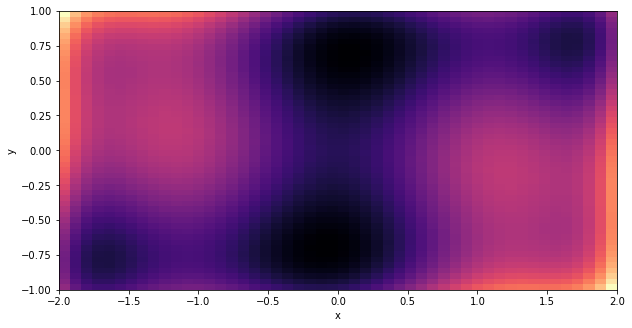

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

x = np.linspace(-2, 2)
y = np.linspace(-1, 1)

X, Y = np.meshgrid(x, y)
Z = f([X,Y])
fig, ax = plt.subplots(figsize=(10, 6))
image = ax.imshow(Z, extent=[-2, 2, -1, 1], cmap='magma')
ax.set_xlabel('x')
ax.set_ylabel('y')

In [6]:
from scipy.optimize import minimize
bound = [(-2,2),(-1,1)]
methods = ['l-bfgs-b', 'cobyla', 'slsqp', 'trust-constr', 'nelder-mead', 'bfgs', 'powell']
np.random.seed(0)
optima =[]
for m in methods:   
    r = minimize(f, x0=np.random.uniform(-1,1,size=2), bounds=bound, method=m)
    optima.append(r.x)

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:541: RuntimeWarning: Method cobyla cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method nelder-mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method bfgs cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


different optimizers may fall in different minima, principally according to the nature of the optimizers themselves (gradien based/free)


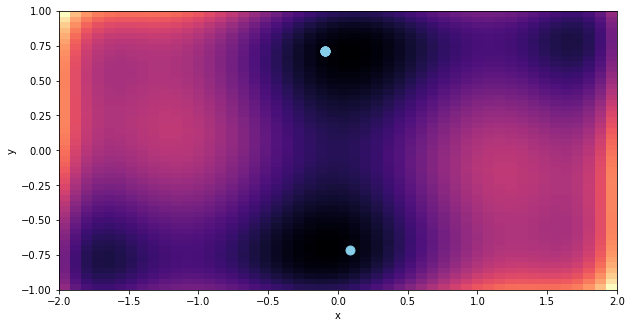

In [8]:
x = np.linspace(-2, 2)
y = np.linspace(-1, 1)

X, Y = np.meshgrid(x, y)
Z = f([X,Y])
fig, ax = plt.subplots(figsize=(10, 6))
image = ax.imshow(Z, extent=[-2, 2, -1, 1], cmap='magma')

for o, m in zip(optima, methods):
    ax.scatter(o[0], o[1], marker='o', s=80, label=m, color ='skyblue')
ax.set_xlabel('x')
ax.set_ylabel('y')
print('different optimizers may fall in different minima, principally according '+\
    'to the nature of the optimizers themselves (gradien based/free)')

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:541: RuntimeWarning: Method cobyla cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method nelder-mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method bfgs cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


different optimizers may fall in different minima, principally according to the nature of the optimizers themselves (gradien based/free). with (0,0) some minimizerz can be stucked in the center since it is a local minima


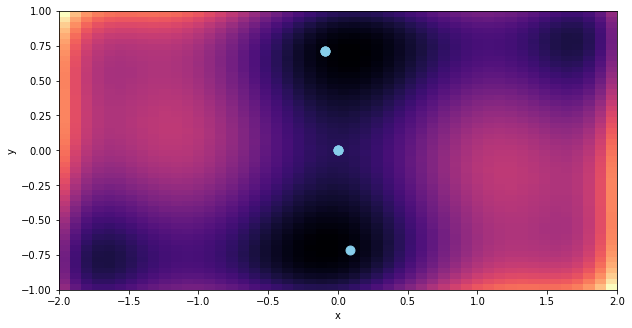

In [11]:
from scipy.optimize import minimize
bound = [(-2,2),(-1,1)]
methods = ['l-bfgs-b', 'cobyla', 'slsqp', 'trust-constr', 'nelder-mead', 'bfgs', 'powell']
np.random.seed(0)
optima =[]
for m in methods:   
    r = minimize(f, x0=(0,0), bounds=bound, method=m)
    optima.append(r.x)

x = np.linspace(-2, 2)
y = np.linspace(-1, 1)

X, Y = np.meshgrid(x, y)
Z = f([X,Y])
fig, ax = plt.subplots(figsize=(10, 6))
image = ax.imshow(Z, extent=[-2, 2, -1, 1], cmap='magma')

for o, m in zip(optima, methods):
    ax.scatter(o[0], o[1], marker='o', s=80, label=m, color ='skyblue')
ax.set_xlabel('x')
ax.set_ylabel('y')
print('different optimizers may fall in different minima, principally according '+\
    'to the nature of the optimizers themselves (gradien based/free). with (0,0) '+
    'some minimizerz can be stucked in the center since it is a local minima')

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

In [12]:
max = np.array([ 17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
min = np.array([ -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Temperature (°C)')

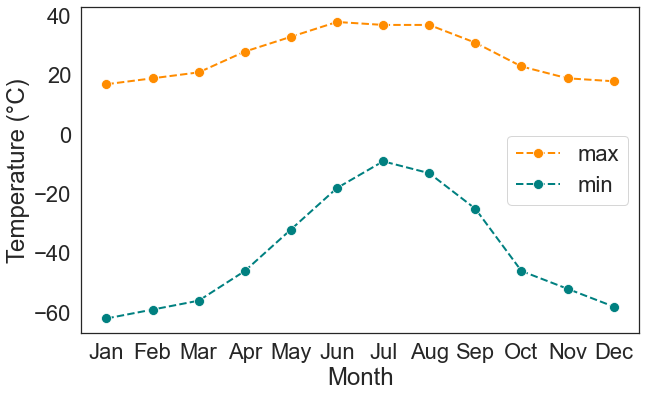

In [15]:
# * Plot these temperatures.

import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_theme(style='white', font_scale=2, palette='Dark2')

month = np.array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

ms=10
sns.lineplot(month, max, ax=ax, color='darkorange', lw=2, label = 'max', ls='--', marker='o', ms=ms)
sns.lineplot(month, min, ax=ax, color='teal', lw=2, label = 'min', ls='--', marker='o', ms=ms)

ax.set_xlabel('Month')
ax.set_ylabel('Temperature (°C)')

In [17]:
# * Find a suitable a function that can describe min and max temperatures. 

def gaussfit(month, mean, sigma, scale, offset):
    from scipy.stats import norm
    return scale*norm.pdf(month, mean, sigma) + offset

def trigonometric(month, omega, phi, scale, offset):
    return scale*np.cos(omega*(month)+phi)+offset


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/pyt

Text(0, 0.5, 'Temperature (°C)')

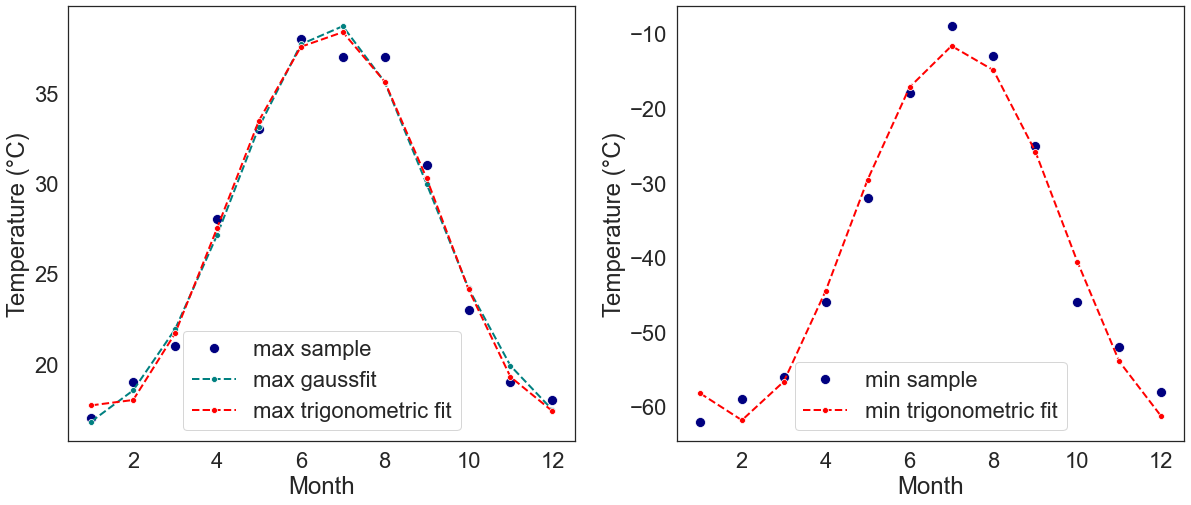

In [18]:
   
# * Fit this function to the data with `scipy.optimize.curve_fit()`.

months = np.array(range(1,13))

from scipy.optimize import curve_fit
popt_maxG, pcov_maxG = curve_fit(gaussfit, months, max)
popt_maxT, pcov_maxT = curve_fit(trigonometric, months, max)

popt_minG, pcov_minG = curve_fit(gaussfit, months, min)
popt_minT, pcov_minT = curve_fit(trigonometric, months, min)


fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
sns.set_theme(style='white', font_scale=2, palette='Dark2')


ms=10
sns.lineplot(months, max, ax=ax[0], color='navy', lw=2, label = 'max sample', ls='', marker='o', ms=ms)
sns.lineplot(months, gaussfit(months, *popt_maxG), ax=ax[0], color='teal', 
            lw=2, label = 'max gaussfit', ls='--', marker='o', ms=6)
sns.lineplot(months, trigonometric(months, *popt_maxT), ax=ax[0], color='red', 
            lw=2, label = 'max trigonometric fit', ls='--', marker='o', ms=6)

sns.lineplot(months, min, ax=ax[1], color='navy', lw=2, label = 'min sample', ls='', marker='o', ms=ms)

sns.lineplot(months, trigonometric(months, *popt_minT), ax=ax[1], color='red', 
            lw=2, label = 'min trigonometric fit', ls='--', marker='o', ms=6)

ax[0].set_xlabel('Month')
ax[0].set_ylabel('Temperature (°C)')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Temperature (°C)')

# * Plot the result. Is the fit reasonable? If not, why?

In [ ]:
# * Is the time offset for min and max temperatures the same within the fit accuracy?


3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.